# **Modèle de traduction seq2seq avec mécanismes d'attention**

# Installation des packages

Dans cette partie, nous installons les packages `einops` et `tensorflow-text`. Ces packages sont essentiels pour la manipulation de données et le traitement du langage naturel avec TensorFlow.

- `einops` est une bibliothèque Python qui permet une manipulation flexible et expressive des axes des tenseurs. Cela facilite la réorganisation des dimensions et le traitement des données dans les réseaux de neurones.
- `tensorflow-text` est une extension de TensorFlow spécialement conçue pour le traitement du langage naturel (NLP). Il fournit diverses fonctionnalités de prétraitement de texte et des méthodes d'encodage de texte pour une utilisation avec les modèles NLP.


In [ ]:
!pip install einops
!pip install tensorflow-text

# Librairies et modules

Dans cette partie, nous importons les bibliothèques et modules nécessaires pour le reste du code. Voici une explication des principales importations :

- `numpy` est une bibliothèque Python utilisée pour effectuer des calculs numériques et des opérations sur des tableaux multidimensionnels (nombres réels, vecteurs, matrices, etc.).
- `typing` est un module Python qui fournit des fonctionnalités pour annoter les types dans le code. Il est utilisé ici pour spécifier les types d'arguments et de valeurs de retour des fonctions.
- `einops` a déjà été expliqué précédemment lors de son installation.
- `matplotlib.pyplot` est utilisé pour créer des visualisations, notamment des graphiques et des tracés.
- `matplotlib.ticker` est utilisé pour la gestion des marques et étiquettes sur les axes des graphiques.

Enfin, nous importons `tensorflow` et `tensorflow_text`, qui sont les bibliothèques principales pour la création de modèles de réseaux de neurones et le traitement du langage naturel avec TensorFlow.


In [ ]:
# Importer les bibliothèques nécessaires
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

# Manipulation des données

## Classe de vérification

Dans cette sous-partie, nous définissons une classe appelée `ShapeChecker` qui nous aide à vérifier les formes des tenseurs lors de la manipulation des données. Cette classe est particulièrement utile pour assurer la compatibilité des dimensions lors de l'utilisation de modèles de réseaux de neurones.

La classe `ShapeChecker` possède une méthode `__call__`, qui prend un tenseur et une liste de noms d'axes et effectue une vérification de forme. Si TensorFlow est en mode d'exécution eager (mode interactif), la vérification est effectuée. Sinon, rien ne se passe, ce qui est pratique lors de l'entraînement de modèles.

Le processus de vérification consiste à analyser la forme du tenseur et à comparer chaque dimension avec les noms donnés. Si un nom d'axe est rencontré pour la première fois, sa longueur est ajoutée au cache de la classe. Si un nom d'axe a déjà été vu, sa longueur actuelle est comparée à l'ancienne. Si les longueurs ne correspondent pas, une erreur est levée pour signaler un conflit de dimension.

Cette classe est un outil précieux pour s'assurer que les données sont bien conformes aux spécifications du modèle, ce qui permet d'éviter des erreurs potentielles lors de l'entraînement et de la prédiction.


In [ ]:
# Cette classe permet de vérifier les formes des tenseurs lors de la manipulation des données
class ShapeChecker():
  def __init__(self):
    # Conserver un cache de chaque nom d'axe vu
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    # Si TensorFlow n'est pas en mode eager, ne fait rien
    if not tf.executing_eagerly():
      return

    # Analyser la forme du tenseur et la comparer avec les noms donnés
    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      # Si la nouvelle dimension est 1 et qu'elle doit être diffusée, continue
      if (broadcast and new_dim == 1):
        continue

      # Si le nom de l'axe est nouveau, ajouter sa longueur au cache
      if old_dim is None:
        self.shapes[name] = new_dim
        continue

      # Si la nouvelle dimension ne correspond pas à l'ancienne, lever une erreur
      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## Téléchargement du dataset

Dans cette sous-partie, nous téléchargeons un fichier contenant les données pour notre modèle de traduction anglais-français. Les données proviennent d'un fichier texte au format TSV (tab-separated values), où chaque ligne représente une paire de phrases (anglais et français) séparées par une tabulation.

Nous utilisons la bibliothèque `pathlib` pour gérer les chemins de fichiers et la fonction `tf.keras.utils.get_file()` pour télécharger le fichier. Le lien de téléchargement pointe vers un jeu de données de traduction couramment utilisé.

Une fois le fichier téléchargé, nous chargeons les données en lisant le texte, en divisant les lignes et en séparant les phrases anglaises et françaises pour former des listes de contextes (`context_raw`) et de cibles (`target_raw`). Nous affichons ensuite la dernière phrase française et anglaise pour vérifier que le chargement des données a été effectué correctement.


In [ ]:
# Télécharger le fichier contenant les données
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'fra-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip',
    extract=True)

path_to_file = '/root/fra.txt'

# Charger les données depuis le fichier spécifié
def load_data(path):
    # Lire le fichier texte
    text = pathlib.Path(path).read_text(encoding='utf-8')

    # Diviser le texte en lignes
    lines = text.splitlines()
    # Diviser chaque ligne en paires de phrases (anglais, français)
    pairs = [line.split('\t') for line in lines]

    # Séparer les phrases anglaises et françaises
    target_raw = [pair[0] for pair in pairs]
    context_raw = [pair[1] for pair in pairs]

    return target_raw, context_raw

# Charger les données et afficher la dernière phrase française et anglaise
target_raw, context_raw = load_data(str(path_to_file))
print(context_raw[-1])
print(target_raw[-1])

Il est peut-être impossible d'obtenir un Corpus complètement dénué de fautes, étant donnée la nature de ce type d'entreprise collaborative. Cependant, si nous encourageons les membres à produire des phrases dans leurs propres langues plutôt que d'expérimenter dans les langues qu'ils apprennent, nous pourrions être en mesure de réduire les erreurs.
It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.


## Datasets d'entraînement et de validation

Dans cette sous-partie, nous préparons les données pour l'entraînement de notre modèle de traduction. Nous divisons les données en deux ensembles : un ensemble d'entraînement et un ensemble de validation.

Nous définissons deux ensembles de booléens, `is_train` et `is_val`, en utilisant une distribution aléatoire uniforme pour répartir les exemples entre les deux ensembles. Environ 80 % des exemples sont destinés à l'entraînement (`is_train=True`) et le reste est destiné à la validation (`is_val=False`).

Nous utilisons ensuite ces ensembles de booléens pour extraire les indices des exemples d'entraînement et de validation à partir des listes `context_raw` et `target_raw`.

Enfin, nous créons deux datasets TensorFlow (`train_raw` et `val_raw`) en utilisant les indices correspondants aux ensembles d'entraînement et de validation. Ces datasets seront utilisés pour entraîner et valider notre modèle de traduction.

Notez que nous mélangeons les exemples lors de la création des datasets pour garantir une variabilité lors de l'entraînement. Nous regroupons également les exemples en lots (`BATCH_SIZE`) pour améliorer l'efficacité du processus d'entraînement.

En conclusion, cette partie prépare les données pour notre modèle de traduction en anglais-français, en divisant les données en ensembles d'entraînement et de validation, et en les transformant en datasets TensorFlow prêts à être utilisés dans le modèle.



In [ ]:
# Paramètres pour la préparation des données
BUFFER_SIZE = len(context_raw)  # Taille du buffer pour le mélange des données.
                               # Ici, elle est définie comme étant la longueur totale des données pour assurer un mélange complet.
BATCH_SIZE = 64                 # Nombre d'exemples à traiter en une fois lors de l'entraînement.

# Créer un tableau de booléens pour déterminer si un exemple doit être utilisé pour l'entraînement.
# Une valeur True signifie que l'exemple est destiné à l'entraînement, tandis qu'une valeur False
# signifie qu'il est destiné à la validation. 80 % des exemples sont destinés à l'entraînement.
is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

# Extraire les indices des exemples d'entraînement et de validation.
train_indices = np.where(is_train)[0]
val_indices = np.where(~is_train)[0]

# Créer des datasets pour l'entraînement et la validation en utilisant les indices précédemment déterminés.
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((np.array(context_raw)[train_indices], np.array(target_raw)[train_indices]))  # Créer un dataset à partir des tableaux
    .shuffle(BUFFER_SIZE)  # Mélanger les exemples pour garantir la variabilité lors de l'entraînement
    .batch(BATCH_SIZE))    # Grouper les exemples en lots (batches) pour l'entraînement
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((np.array(context_raw)[val_indices], np.array(target_raw)[val_indices]))  # De même pour les données de validation
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

# Afficher quelques exemples de l'ensemble d'entraînement pour vérifier le format
for example_context_strings, example_target_strings in train_raw.take(1):  # Prendre un lot du dataset d'entraînement
  print(example_context_strings[:5])  # Afficher les 5 premiers contextes du lot
  print()
  print(example_target_strings[:5])  # Afficher les 5 premières cibles correspondantes
  break

tf.Tensor(
[b'Je ne parviens pas \xc3\xa0 le faire de suite.'
 b'La seule chose qui importe est si oui ou non tu peux faire le boulot.'
 b'Vous trouverez \xc3\xa7a dans une droguerie.'
 b'Je ne veux pas oublier ce moment.'
 b"Je sais que vous n'\xc3\xaates pas s\xc3\xa9rieuses."], shape=(5,), dtype=string)

tf.Tensor(
[b"I can't do it right away."
 b'The only thing that matters is whether or not you can do the job.'
 b'You will find this in a hardware store.'
 b"I don't want to forget this moment." b"I know you're not serious."], shape=(5,), dtype=string)


# Prétraitement

## Standardisation du texte

Dans cette sous-partie, nous effectuons le prétraitement du texte avant de l'utiliser pour entraîner notre modèle de traduction. Le but du prétraitement est de normaliser le texte en éliminant les variations dues aux caractères spéciaux et à la casse, et de le transformer en une séquence de tokens.

Nous utilisons l'exemple de texte "Êtes-vous un chercheur en Intelligence Artificielle ?" pour illustrer le processus de normalisation. Nous utilisons d'abord la fonction `tf_text.normalize_utf8()` pour décomposer les caractères en leurs formes compatibles (NFKD) et les transformer en texte Unicode normalisé. Ensuite, nous convertissons le texte en minuscules et supprimons tout caractère qui n'est pas une lettre de l'alphabet anglais, un espace, un point, un point d'interrogation, une virgule ou un point d'exclamation. Nous ajoutons également des espaces autour de la ponctuation pour les séparer comme des tokens distincts.

Enfin, nous ajoutons des tokens spéciaux `[START]` et `[END]` autour du texte pour indiquer le début et la fin de la séquence de tokens. Cette étape est essentielle pour les modèles de traduction afin qu'ils sachent quand commencer et terminer la génération de texte.

Le prétraitement standardise le texte et le transforme en une séquence de tokens prête à être utilisée par le modèle de traduction.


In [ ]:
# Exemple de texte à transformer
example_text = tf.constant('Êtes-vous un chercheur en Intelligence Artificielle ?')

# Afficher le texte initial
print(example_text.numpy())
# Normaliser le texte pour éliminer les variations dues aux caractères spéciaux ou à la casse, par exemple.
# Ici, 'NFKD' est un type de normalisation Unicode qui décompose les caractères en leurs formes compatibles.
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc3\x8ates-vous un chercheur en Intelligence Artificielle ?'
b'E\xcc\x82tes-vous un chercheur en Intelligence Artificielle ?'


In [ ]:
# Fonction pour transformer le texte : le mettre en minuscule et séparer la ponctuation
def tf_lower_and_split_punct(text):
  # Séparer les caractères accentués
  text = tf_text.normalize_utf8(text, 'NFKD')
  # Convertir le texte en minuscule
  text = tf.strings.lower(text)
  # Garder l'espace, les lettres de a à z, et certains signes de ponctuation
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Ajouter des espaces autour de la ponctuation
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Supprimer les espaces superflus
  text = tf.strings.strip(text)

  # Ajouter des tokens de début et de fin autour du texte
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

# Afficher l'exemple transformé
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Êtes-vous un chercheur en Intelligence Artificielle ?
[START] etesvous un chercheur en intelligence artificielle  ? [END]


## Vectorisation

Dans cette sous-partie, nous effectuons la vectorisation des données textuelles pour préparer l'entrée de notre modèle de traduction. La vectorisation consiste à convertir les mots en indices numériques (tokens) en utilisant un dictionnaire de vocabulaire.

Nous définissons une taille maximale pour le vocabulaire (`max_vocab_size`) qui limitera le nombre de mots pris en compte pour l'indexation. Ensuite, nous créons deux processeurs de texte, un pour le contexte (anglais) et l'autre pour la cible (français).

Chaque processeur est une couche de vectorisation de texte, qui prend en entrée le texte normalisé (à partir de la sous-partie précédente) et le transforme en séquences de tokens. Nous utilisons la fonction `tf.keras.layers.TextVectorization` pour cela, en spécifiant la fonction de normalisation, la taille maximale du vocabulaire et l'option `ragged=True` pour indiquer que les séquences auront des longueurs variables.

Ensuite, nous "adaptons" les processeurs de texte aux données d'entraînement en utilisant la méthode `.adapt()` avec le dataset d'entraînement. Cela permet aux processeurs de texte d'apprendre le vocabulaire en utilisant les données d'entraînement.

Nous affichons ensuite les 10 premiers mots du vocabulaire pour vérifier ce que les processeurs de texte ont appris.

Enfin, nous utilisons les processeurs de texte pour convertir les exemples de chaînes contextuelles en séquences de tokens numériques. Cela nous permet de vérifier si la tokenisation fonctionne correctement et d'afficher une représentation visuelle des tokens générés et de leur masque (où les tokens sont présents et où ils ne le sont pas).

La vectorisation prépare les données textuelles en convertissant les mots en indices numériques (tokens) pour le traitement par le modèle de traduction.


In [ ]:
# On définie une taille maximale pour le vocabulaire.
max_vocab_size = 5000

# On crée un processeur de texte pour le contexte (anglais). Ce processeur est une couche
# de vectorisation de texte qui permet de convertir les textes en séquences de tokens.
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct, # Fonction pour normaliser le texte
    max_tokens=max_vocab_size,            # Taille maximale du vocabulaire
    ragged=True)                          # Renvoie un tensor de forme variable

In [ ]:
# Le processeur de texte est "adapté" aux données d'entraînement. C'est comme ajuster un
# tokenizer sur des données: il apprend le vocabulaire.
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Affiche les 10 premiers mots du vocabulaire pour vérifier ce qu'il a appris.
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'je', 'de', 'a', '?', 'pas']

In [ ]:
# De la même manière, on crée un processeur de texte pour la cible (français).
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

# Adapter le processeur de texte aux cibles du dataset d'entraînement.
target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'i', 'you', 'to', 'the', '?']

In [ ]:
# Exemple de tokens générés par le processeur de texte. On prend quelques exemples
# de chaînes contextuelles et on les tokenise.
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 5, 12, 1051, 9, 7, 13, 32, 6, 771, 4, 3],
 [2, 11, 252, 72, 39, 1605, 17, 50, 805, 58, 240, 20, 70, 32, 13, 552, 4, 3],
 [2, 14, 3495, 30, 34, 24, 1, 4, 3]]>

In [ ]:
# Convertit les tokens en mots en utilisant le vocabulaire. Cela nous permet de
# vérifier si la tokenisation fonctionne correctement.
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] je ne parviens pas a le faire de suite . [END]'

Text(0.5, 1.0, 'Mask')

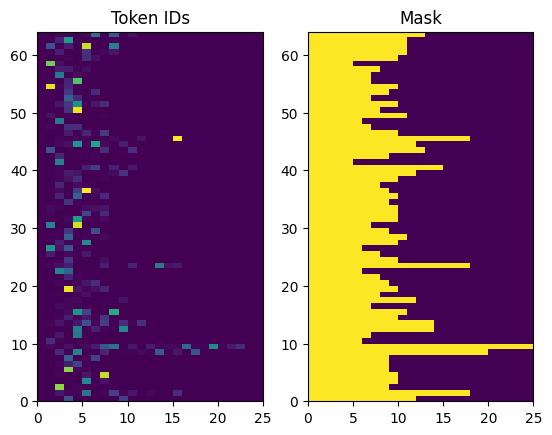

In [ ]:
# Affiche une représentation visuelle des IDs de tokens et de leur masque.
# Le masque indique où les tokens sont présents (valeur 1) et où ils ne le sont pas (valeur 0).
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [ ]:
# Fonction pour traiter le texte avant de le fournir au modèle. Elle convertit
# le contexte et la cible en tokens, et crée également les entrées et les sorties
# pour la cible (en décalant d'un token).
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out

# Applique cette fonction de traitement aux datasets d'entraînement et de validation.
train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
# Affiche un exemple de données traitées pour vérifier la structure des tokens.
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[  2 576   1   4   3   0   0   0   0   0]

[ 2 26 64  7 32 61  4  0  0  0]
[26 64  7 32 61  4  3  0  0  0]


# Le modèle encodeur/décodeur

In [ ]:
# On définit le nombre d'unités pour les couches d'encodage et d'attention.
UNITS = 256

Dans cette partie, nous définissons le modèle de traduction anglais-français en utilisant l'architecture d'encodeur-décodeur. Ce modèle est une architecture couramment utilisée pour les tâches de traduction et de génération de texte.

Nous utilisons des couches d'encodage et d'attention pour capturer les informations sémantiques des phrases en entrée et générer les traductions en sortie.

- `UNITS` représente le nombre d'unités (neurones) pour les couches d'encodage et d'attention. Ce paramètre est défini à 256, mais il peut être ajusté en fonction des besoins et de la complexité du modèle.

Le modèle d'encodeur-décodeur est une architecture puissante qui peut être entraînée à générer des traductions de haute qualité en fonction des paires de phrases d'entraînement. La combinaison de la vectorisation du texte, du prétraitement et de l'architecture du modèle permettra d'obtenir un système de traduction efficace et précis.


## L'encodeur

Dans cette sous-partie, nous mettons en œuvre la couche d'encodeur personnalisée. L'encodeur transforme une séquence de texte en une séquence de vecteurs. Il utilise deux composants principaux : la couche d'embedding et une couche RNN bidirectionnelle.

- La couche d'embedding (`self.embedding`) est utilisée pour convertir les tokens (mots) en vecteurs denses. Cela permet de représenter le texte de manière continue et facilite l'apprentissage des relations entre les mots. L'embedding est spécifié par le nombre d'unités (`units`) que chaque mot sera représenté.

- La couche RNN bidirectionnelle (`self.rnn`) traite les vecteurs d'embedding séquentiellement. Elle prend en entrée les vecteurs d'embedding et retourne une séquence d'états cachés, permettant de capturer les informations contextuelles dans les deux directions (avant et arrière) du texte. L'option `merge_mode='sum'` signifie que les sorties des deux directions sont sommées.

La méthode `call` de l'encodeur prend une séquence d'entrée `x` et effectue les opérations suivantes :

1. Conversion des tokens en vecteurs d'embedding à l'aide de la couche d'embedding.
2. Traitement des vecteurs d'embedding avec la couche RNN bidirectionnelle (`self.rnn`).
3. Renvoi de la séquence traitée.

La méthode `convert_input` est utilisée pour convertir un texte brut en sa représentation encodée à l'aide de l'encodeur. Elle prend en entrée un texte, le convertit en tokens et le passe à l'encodeur pour obtenir les vecteurs d'embedding correspondants.


In [ ]:
# L'encodeur est une couche personnalisée qui convertit une séquence de texte en une séquence de vecteurs.
class Encoder(tf.keras.layers.Layer):
  # Initialisation de l'encodeur
  def __init__(self, text_processor, units):
    # Initialisation de la superclasse
    super(Encoder, self).__init__()
    # Le traitement du texte est nécessaire pour tokeniser le texte
    self.text_processor = text_processor
    # La taille du vocabulaire détermine le nombre de mots différents qui peuvent être traités
    self.vocab_size = text_processor.vocabulary_size()
    # Le nombre d'unités dans les couches RNN et d'embedding
    self.units = units

    # La couche d'embedding convertit les tokens (mots) en vecteurs
    # Cela permet d'avoir une représentation dense du texte
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

    # La couche RNN (GRU ici) traite ces vecteurs séquentiellement
    # Bidirectionnel signifie que le RNN traite le texte dans les deux directions (avant et arrière)
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units, return_sequences=True, recurrent_initializer='glorot_uniform'))

  # Cette méthode est appelée pour traiter une séquence d'entrée x
  def call(self, x):
    # Une instance pour vérifier la forme des tenseurs
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # Conversion des tokens en vecteurs
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # Traitement des vecteurs avec RNN
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # Renvoyer la séquence traitée
    return x

  # Cette méthode convertit un texte brut en sa représentation encodée
  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encoder la séquence d'entrée

# Instanciation de l'encodeur
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Tokens de contexte, forme (batch, s): {ex_context_tok.shape}')
print(f'Sortie de l\'encodeur, forme (batch, s, units): {ex_context.shape}')

Tokens de contexte, forme (batch, s): (64, 16)
Sortie de l'encodeur, forme (batch, s, units): (64, 16, 256)


## La couche d'attention

Dans cette sous-partie, nous définissons la couche d'attention personnalisée (`CrossAttention`). Cette couche permet de concentrer le modèle sur certaines parties du contexte lors de la traduction.

- La couche utilise `tf.keras.layers.MultiHeadAttention` (`self.mha`) qui est une méthode d'attention permettant de traiter l'information de plusieurs manières à la fois.
- `self.layernorm` est une couche de normalisation qui améliore la stabilité de l'apprentissage.
- `self.add` combine les sorties de l'attention avec les sorties précédentes.

La méthode `call` de la couche d'attention prend en entrée une séquence `x` et le contexte `context`. Elle effectue les opérations suivantes :

1. Obtention des poids d'attention et de la sortie en utilisant `tf.keras.layers.MultiHeadAttention`.
2. Combinaison des sorties en utilisant `self.add`.
3. Normalisation des sorties en utilisant `self.layernorm`.

Cette couche est utilisée dans le décodeur pour se concentrer sur le contexte pertinent pendant la génération de la traduction.


In [ ]:
# Cette couche fournit un mécanisme d'attention pour focaliser sur certaines parties du contexte lors de la traduction
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    # MultiHeadAttention est une méthode d'attention qui traite l'information de plusieurs manières à la fois
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    # Obtention des poids d'attention et sortie
    attn_output, attn_scores = self.mha(query=x, value=context, return_attention_scores=True)
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    self.last_attention_weights = attn_scores

    # Combinaison des sorties
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

attention_layer = CrossAttention(UNITS)

# Assister aux tokens encodés pour vérifier le fonctionnement de la couche d'attention
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(), output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)
result = attention_layer(ex_tar_embed, ex_context)

# Affichage des formes pour comprendre la transformation des données
print(f'Séquence de contexte, forme (batch, s, units): {ex_context.shape}')
print(f'Séquence cible, forme (batch, t, units): {ex_tar_embed.shape}')
print(f'Résultat de l\'attention, forme (batch, t, units): {result.shape}')
print(f'Poids de l\'attention, forme (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Séquence de contexte, forme (batch, s, units): (64, 16, 256)
Séquence cible, forme (batch, t, units): (64, 13, 256)
Résultat de l'attention, forme (batch, t, units): (64, 13, 256)
Poids de l'attention, forme (batch, t, s):    (64, 13, 16)


In [ ]:
# Calculer la somme des poids d'attention pour vérifier qu'ils somment bien à 1
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 1.        , 0.9999999 , 1.        ,
       1.        , 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994], dtype=float32)

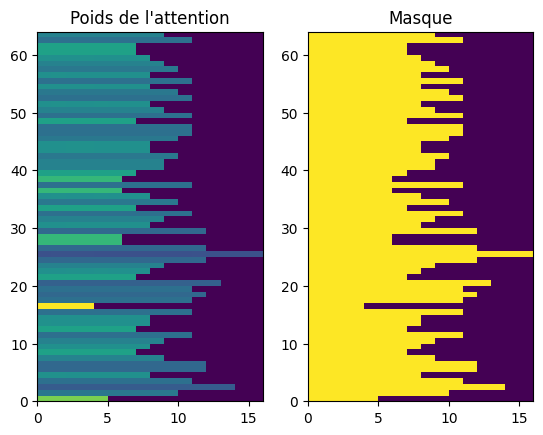

In [ ]:
# Visualisation des poids d'attention

# Récupération des poids d'attention à partir de la dernière couche d'attention
attention_weights = attention_layer.last_attention_weights
# Création d'un masque pour exclure les tokens qui sont des zéros (c'est-à-dire des paddings)
mask=(ex_context_tok != 0).numpy()

# Création d'une figure avec 2 subplots côte à côte
plt.subplot(1, 2, 1)
# Affichage des poids d'attention multipliés par le masque (pour supprimer l'affichage des paddings)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Poids de l\'attention')

plt.subplot(1, 2, 2)
# Affichage du masque lui-même pour visualiser les régions effectivement masquées
plt.pcolormesh(mask)
plt.title('Masque');

## Le décodeur


Dans cette sous-partie, nous mettons en œuvre la classe du décodeur personnalisé. Le décodeur prend le contexte encodé et génère une séquence cible (traduction) mot par mot.

Le décodeur a plusieurs composants importants :

- `self.word_to_id` et `self.id_to_word` sont des couches de conversion de mots en identifiants uniques et vice versa. Elles sont utilisées pour gérer le vocabulaire des séquences cibles.

- `self.start_token` et `self.end_token` représentent les identifiants des tokens de début et de fin de séquence. Ils sont utilisés pour indiquer quand commencer et arrêter la génération de la traduction.

- `self.embedding` est une couche d'embedding pour convertir les identifiants de tokens en vecteurs d'embedding.

- `self.rnn` est une couche RNN (GRU) utilisée pour traiter les séquences cibles.

- `self.attention` est la couche d'attention (`CrossAttention`) utilisée pour se concentrer sur le contexte pendant la génération de la traduction.

- `self.output_layer` est une couche dense qui prédit le prochain token en fonction des sorties du décodeur.

La méthode `call` du décodeur prend en entrée le contexte encodé `context`, les tokens d'entrée `x`, l'état du décodeur `state` et une option `return_state`. Elle effectue les opérations suivantes :

1. Conversion des tokens d'entrée en vecteurs d'embedding à l'aide de la couche d'embedding.
2. Traitement de la séquence d'entrée avec la couche RNN pour obtenir la séquence de sorties `x`.
3. Utilisation de la couche d'attention pour se concentrer sur le contexte pertinent pendant la génération de la traduction.
4. Prédiction du prochain token avec la couche de sortie.

La méthode `get_initial_state` est utilisée pour initialiser l'état du décodeur avant la traduction. Elle renvoie le token de début pour chaque séquence du batch, initialise la variable "done" à faux pour toutes les séquences et renvoie l'état initial du RNN.

La méthode `tokens_to_text` convertit les tokens en texte, en utilisant le dictionnaire inversé `self.id_to_word`. Elle joint les mots pour former une phrase et retire les tokens de début et de fin.

La méthode `get_next_token` est utilisée pour prédire le prochain token lors de la génération de la traduction. Elle prend en entrée le contexte, le prochain token, l'état du décodeur, la variable "done" (indiquant si une séquence est terminée) et une option de température pour la génération aléatoire. Si la température est égale à 0, le token est choisi avec la probabilité la plus élevée (mode déterministe). Sinon, le token est choisi de manière aléatoire en fonction des logits (mode stochastique). Cette méthode est utilisée pour itérer sur les tokens et générer la traduction complète mot par mot.


In [ ]:
# Définition de la classe du décodeur
class Decoder(tf.keras.layers.Layer):
  # Définir une méthode de classe pour ajouter dynamiquement des méthodes à la classe
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  # Initialisation de la classe décodeur
  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()  # Initialiser la superclasse Layer
    # Text processor pour traiter les séquences cibles
    self.text_processor = text_processor
    # Taille du vocabulaire des séquences cibles
    self.vocab_size = text_processor.vocabulary_size()
    # Conversion de mots en identifiants uniques
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    # Conversion inverse d'identifiants uniques en mots
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    # Identifier le token de début et de fin
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')
    # Définir le nombre d'unités pour le RNN et la couche d'embedding
    self.units = units
    # Convertir les identifiants de tokens en vecteurs d'embedding
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)
    # RNN pour traiter les séquences cibles
    self.rnn = tf.keras.layers.GRU(units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    # Couche d'attention pour se concentrer sur le contexte pertinent
    self.attention = CrossAttention(units)
    # Couche de sortie pour prédire le prochain token
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [ ]:
# La méthode "call" pour traiter les séquences avec le décodeur
@Decoder.add_method
def call(self, context, x, state=None, return_state=False):
  shape_checker = ShapeChecker()  # Utilitaire pour vérifier les dimensions des tensors
  # Vérifier les dimensions du tensor d'entrée
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')
  # Convertir les identifiants de tokens en vecteurs d'embedding
  x = self.embedding(x)
  shape_checker(x, 'batch t units')
  # Traiter la séquence avec le RNN
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')
  # Utiliser la couche d'attention pour se concentrer sur le contexte pertinent
  x = self.attention(x, context)
  # Sauvegarder les poids d'attention pour une éventuelle visualisation
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')
  # Prédire le prochain token avec la couche de sortie
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')
  # Renvoyer soit les logits avec l'état, soit juste les logits en fonction de "return_state"
  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
# Instancier le décodeur avec les paramètres appropriés
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
# Tester le décodeur avec un exemple de contexte et une séquence d'entrée
logits = decoder(ex_context, ex_tar_in)

# Afficher les formes des tensors pour s'assurer qu'ils sont corrects
print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 16, 256)
input target tokens shape: (batch, t) (64, 13)
logits shape shape: (batch, target_vocabulary_size) (64, 13, 5000)


In [ ]:
# Définition des méthodes supplémentaires pour le décodeur

# Cette méthode initialise l'état du décodeur avant la traduction
@Decoder.add_method
def get_initial_state(self, context):
  # Obtenir la taille du batch à partir du contexte
  batch_size = tf.shape(context)[0]
  # Créer le token de départ pour chaque séquence du batch
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  # Initialiser la variable "done" à faux pour toutes les séquences
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  # Convertir les tokens de départ en embeddings
  embedded = self.embedding(start_tokens)
  # Retourner le token de départ, la variable "done", et l'état initial du RNN
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

# Convertir les tokens en texte
@Decoder.add_method
def tokens_to_text(self, tokens):
  # Convertir les identifiants de tokens en mots
  words = self.id_to_word(tokens)
  # Joindre les mots pour former une phrase
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  # Retirer les tokens de départ et de fin
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

# Prédire le prochain token
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  # Obtenir les logits et l'état du décodeur
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  # Si la température est égale à 0, choisir le token avec la probabilité la plus élevée
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    # Sinon, choisir un token de manière aléatoire en fonction des logits
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # Si un token de fin est généré, mettre à jour la variable "done"
  done = done | (next_token == self.end_token)
  # Si une séquence est terminée, produire uniquement du padding
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [ ]:
# Initialiser les variables pour la boucle de traduction
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

# Boucle pour générer une traduction
for n in range(10):
  # Obtenir le prochain token
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Ajouter le token à la liste des tokens
  tokens.append(next_token)

# Concaténer tous les tokens pour obtenir la traduction complète
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convertir les tokens en texte
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'seeing require embarrassed laundry guy relationship consult terrified degree proceed',
       b'thanked trouble ignoring summer instruments message child duck u tennis',
       b'stuck stew flexible monkeys chubby construction bees mostly gets cello'],
      dtype=object)

# Le modèle


Dans cette partie, nous créons une classe `Translator` pour combiner l'encodeur et le décodeur en un modèle complet de traduction. La classe `Translator` hérite de `tf.keras.Model`, ce qui nous permet de définir la méthode `call` pour exécuter la traduction.

La méthode `call` prend en entrée un tuple `inputs` contenant le contexte et la séquence cible `x`. Elle effectue les opérations suivantes :

1. Exécuter l'encodeur pour obtenir le contexte encodé à partir du contexte d'entrée (`context = self.encoder(context)`).
2. Exécuter le décodeur pour obtenir les logits de sortie en utilisant le contexte encodé et la séquence cible (`logits = self.decoder(context, x)`).

Nous définissons également une méthode de traduction (`translate`) pour le modèle `Translator`. Cette méthode prend un texte brut en entrée et renvoie sa traduction en utilisant le modèle entraîné. Elle utilise l'encodeur pour convertir le texte brut en sa représentation encodée (`context = self.encoder.convert_input(texts)`), puis utilise le décodeur pour générer la traduction mot par mot en utilisant la méthode `get_next_token` du décodeur.

Nous ajoutons également une méthode pour visualiser l'attention pendant la traduction (`plot_attention`). Cette méthode prend un texte brut en entrée, utilise le modèle pour le traduire, et affiche les poids d'attention sur une matrice pour visualiser quelles parties du contexte ont été utilisées pour générer chaque mot de la traduction.


In [ ]:
# Classe Translator pour combiner l'encodeur et le décodeur
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Construire l'encodeur et le décodeur
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  # Définition de la méthode "call" pour exécuter la traduction
  def call(self, inputs):
    context, x = inputs
    # Exécuter l'encodeur pour obtenir le contexte encodé
    context = self.encoder(context)
    # Exécuter le décodeur pour obtenir les logits
    logits = self.decoder(context, x)

    # Suppression du masque Keras (note spécifique au code, probablement liée à une contrainte technique)
    try:
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
# Création d'une instance du modèle Translator et test sur un exemple
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 16)
Target tokens, shape: (batch, t) (64, 13)
logits, shape: (batch, t, target_vocabulary_size) (64, 13, 5000)


## Entraînement


Dans cette sous-partie, nous définissons les fonctions de perte et de précision personnalisées pour le modèle, adaptées au processus d'entraînement du modèle de séquence à séquence.

- La fonction `masked_loss` calcule la perte en ignorant les tokens de padding. Cela est nécessaire car les séquences cibles peuvent avoir des longueurs différentes et sont complétées par des tokens de padding. En masquant ces tokens de padding, la perte n'est calculée que sur les tokens pertinents.

- La fonction `masked_acc` calcule la précision en ignorant également les tokens de padding. Tout comme la perte masquée, la précision masquée s'assure que la métrique n'est calculée que sur les tokens pertinents et ignore les tokens de padding.

Ensuite, nous compilons le modèle en utilisant un optimiseur, la fonction de perte masquée et les métriques masquées. Nous utilisons l'optimiseur Adam pour les mises à jour des poids, et nous utilisons les fonctions de perte et de précision masquées pour évaluer les erreurs du modèle et surveiller sa performance pendant l'entraînement.

Enfin, nous évaluons la performance du modèle sur un jeu de données de validation pour voir ses performances initiales avant l'entraînement.

Nous utilisons ensuite la méthode `fit` pour entraîner le modèle sur les données d'entraînement. Nous répétons les données d'entraînement pour plusieurs époques et utilisons la validation pour surveiller la performance. Nous utilisons également le rappel `tf.keras.callbacks.EarlyStopping` pour arrêter l'entraînement si la perte ne s'améliore pas pendant un certain nombre d'époques consécutives. Ceci évite un surapprentissage inutile et nous permet de choisir le meilleur modèle en fonction de la performance sur les données de validation.


In [ ]:
# Définir les fonctions de perte et de précision pour le modèle


# La fonction "masked_loss" est conçue pour calculer la perte en ignorant les tokens de padding.
# Cela est nécessaire car lors de l'entraînement d'un modèle de séquence à séquence,
# les séquences peuvent avoir des longueurs différentes et sont complétées par des tokens de padding.
# En masquant ces tokens de padding, on s'assure que la perte n'est calculée que sur les tokens pertinents.

def masked_loss(y_true, y_pred):
    # Calcul de la perte pour chaque élément du batch
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # On retourne le résultat
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

# La fonction "masked_acc" est conçue pour calculer la précision en ignorant également les tokens de padding.
# Tout comme la perte masquée, la précision masquée s'assure que la métrique n'est calculée que sur
# les tokens pertinents et ignore les tokens de padding.

def masked_acc(y_true, y_pred):
    # Calcul de la perte pour chaque élément du batch
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
# Compiler le modèle avec un optimiseur, une fonction de perte et des métriques

# La méthode compile configure le processus d'apprentissage du modèle
model.compile(optimizer='adam', # Utilise l'optimiseur "adam" pour les mises à jour des poids
              loss=masked_loss, # Fonction de perte personnalisée pour évaluer les erreurs du modèle
              metrics=[masked_acc, masked_loss]) # Métriques pour surveiller la performance pendant l'entraînement

In [ ]:
# Calculer la taille du vocabulaire cible

# Obtenir la taille du vocabulaire à partir du processeur de texte
vocab_size = 1.0 * target_text_processor.vocabulary_size()

# Calculer la perte et la précision attendues pour un modèle qui prédit les sorties au hasard
{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [ ]:
# Évaluer la performance du modèle sur un jeu de données de validation

# Évalue la performance actuelle du modèle sur les données de validation
model.evaluate(val_ds, steps=20, return_dict=True)

# Entraîner le modèle

# Utiliser la méthode "fit" pour entraîner le modèle sur les données d'entraînement
history = model.fit(
    train_ds.repeat(), # Répète les données d'entraînement pour plusieurs passages (époques)
    epochs=100, # Nombre d'époques d'entraînement
    steps_per_epoch = 100, # Nombre de lots traités avant d'aller à l'époque suivante
    validation_data=val_ds, # Données utilisées pour la validation
    validation_steps = 20, # Nombre de lots de validation à utiliser à chaque époque
    callbacks=[ # Mécanismes pour intervenir pendant l'entraînement
        tf.keras.callbacks.EarlyStopping(patience=3)]) # Arrête l'entraînement si la perte ne s'améliore pas pendant 3 époques consécutives

20/20 [==============================] - 11s 172ms/step - loss: 8.5151 - masked_acc: 0.0000e+00 - masked_loss: 8.5151
Epoch 1/100
100/100 [==============================] - 65s 514ms/step - loss: 4.9147 - masked_acc: 0.2720 - masked_loss: 4.9147 - val_loss: 3.9751 - val_masked_acc: 0.3646 - val_masked_loss: 3.9751
Epoch 2/100
100/100 [==============================] - 51s 507ms/step - loss: 3.5843 - masked_acc: 0.4169 - masked_loss: 3.5843 - val_loss: 3.2326 - val_masked_acc: 0.4627 - val_masked_loss: 3.2326
Epoch 3/100
100/100 [==============================] - 49s 492ms/step - loss: 3.0140 - masked_acc: 0.4940 - masked_loss: 3.0140 - val_loss: 2.7687 - val_masked_acc: 0.5311 - val_masked_loss: 2.7687
Epoch 4/100
100/100 [==============================] - 51s 513ms/step - loss: 2.6464 - masked_acc: 0.5456 - masked_loss: 2.6464 - val_loss: 2.4857 - val_masked_acc: 0.5618 - val_masked_loss: 2.4857
Epoch 5/100
100/100 [==============================] - 51s 514ms/step - loss: 2.3581 - mas

## Visualisation des résultats


Dans cette sous-partie, nous visualisons les résultats de l'entraînement en affichant les courbes de perte et de précision pendant l'entraînement. Cela nous permet de voir comment la perte et la précision évoluent au fur et à mesure des époques, ce qui est utile pour évaluer la performance du modèle.


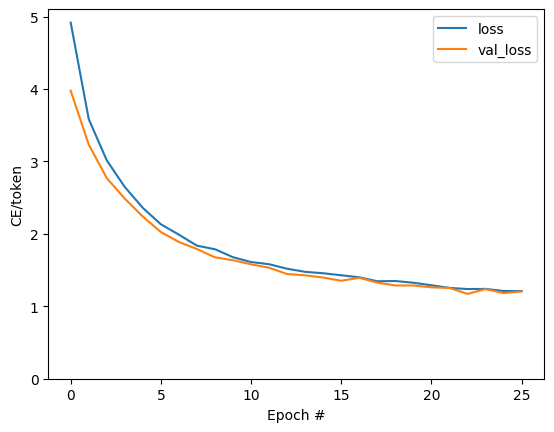

In [ ]:
# Afficher la courbe de la perte pendant l'entraînement
plt.plot(history.history['loss'], label='loss') # Courbe de la perte d'entraînement
plt.plot(history.history['val_loss'], label='val_loss') # Courbe de la perte de validation
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #') # Axe des abscisses
plt.ylabel('CE/token') # Axe des ordonnées
plt.legend()

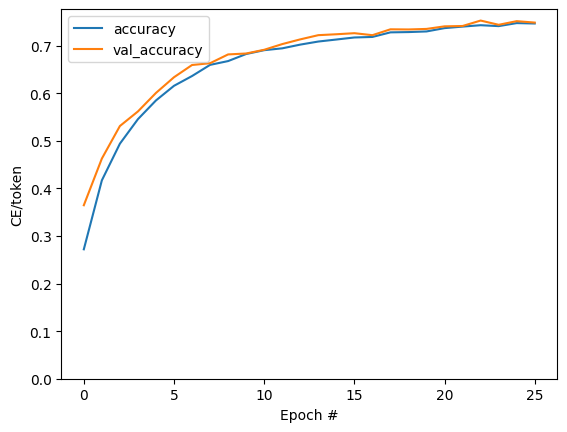

In [ ]:
# Afficher la courbe de la précision pendant l'entraînement
plt.plot(history.history['masked_acc'], label='accuracy') # Courbe de la précision d'entraînement
plt.plot(history.history['val_masked_acc'], label='val_accuracy') # Courbe de la précision de validation
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Traduction


Enfin, dans cette sous-partie, nous ajoutons une méthode de traduction à la classe `Translator`. Cette méthode prend en entrée un texte brut et renvoie sa traduction en utilisant le modèle entraîné.

Nous utilisons l'encodeur pour convertir le texte brut en sa représentation encodée. Ensuite, nous initialisons les variables pour la boucle de génération de tokens et itérons pour générer le prochain token jusqu'à atteindre la longueur maximale de la sortie ou jusqu'à ce que toutes les séquences soient terminées. Nous utilisons la méthode `get_next_token` du décodeur pour générer le prochain token en fonction des poids d'attention calculés par la couche d'attention. Finalement, nous concaténons les listes de tokens pour obtenir la traduction complète et la renvoyons.

Nous ajoutons également une méthode `plot_attention` pour visualiser les poids d'attention lors de la traduction. Cette méthode prend un texte brut en entrée, utilise le modèle pour le traduire, et affiche les poids d'attention sur une matrice pour visualiser quelles parties du contexte ont été utilisées pour générer chaque mot de la traduction.


In [ ]:
# Ajouter une méthode de traduction à la classe Translator

@Translator.add_method
def translate(self,
              texts, *,
              max_length=50, # Longueur maximale de la sortie
              temperature=0.0): # Paramètre pour contrôler la diversité de la sortie
  # Convertit le texte brut en représentation encodée
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0] # Obtenir la taille du lot

  # Initialiser les variables pour la boucle de génération de tokens
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Générer le token suivant
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done, state, temperature)

    # Ajouter le token et les poids d'attention à leurs listes respectives
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    # Arrêter la génération si tous les textes sont finis
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Concaténer les listes de tokens et de poids d'attention
  tokens = tf.concat(tokens, axis=-1)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)

  # Convertir les tokens en texte
  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
# Tester la méthode de traduction

# Traduire un exemple de phrase
result = model.translate(['J\'aime les pommes.'])
# Afficher la traduction
result[0].numpy().decode()

'i like apples . '

In [ ]:
# Ajouter une méthode pour visualiser l'attention lors de la traduction

@Translator.add_method
def plot_attention(self, text, **kwargs):
  # Assurez-vous que le texte est une chaîne
  assert isinstance(text, str)
  # Obtenir la traduction du texte
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0] # Récupérer les poids d'attention

  # Prétraitement des textes pour l'affichage
  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()
  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  # Créer un graphique pour visualiser les poids d'attention
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis', vmin=0.0)
  fontdict = {'fontsize': 14}
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.set_xlabel('Texte en entrée')
  ax.set_ylabel('Texte en sortie')

## Visualiser l'attention

Dans cette sous-partie, nous testons la visualisation des poids d'attention pendant la traduction. Nous utilisons la méthode `plot_attention` du modèle pour afficher les poids d'attention entre le texte d'entrée et la traduction générée. Nous testons d'abord sur un exemple court, puis sur un texte plus long.


<ipython-input-179-0737ce3acf21>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-179-0737ce3acf21>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


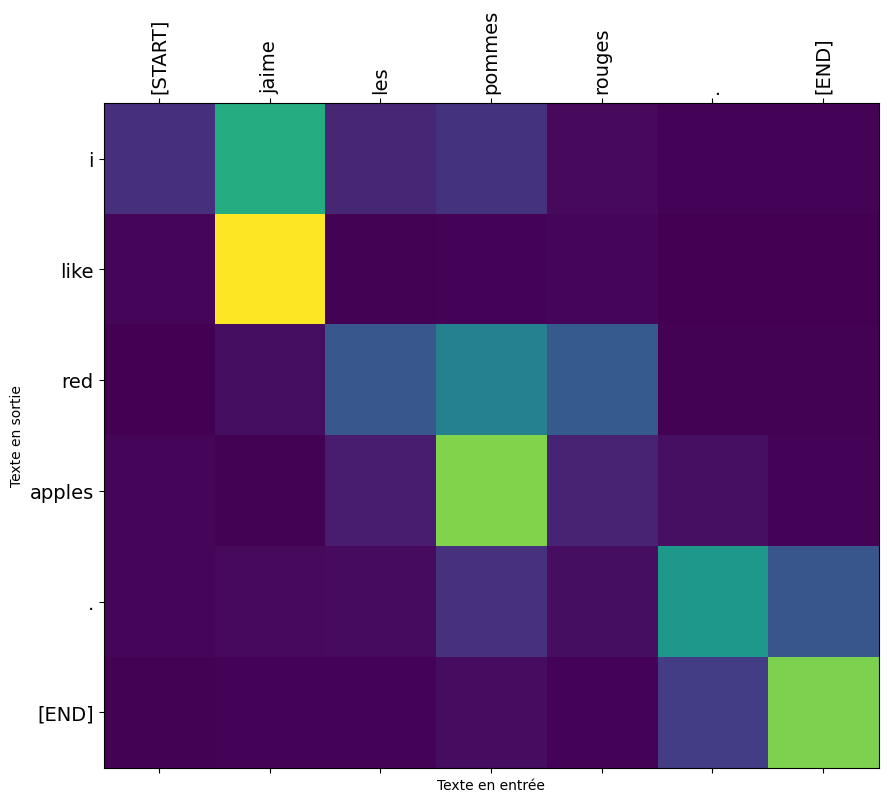

In [ ]:
# Tester la visualisation de l'attention
model.plot_attention('J\'aime les pommes rouges.')

Sortie attendue:
 It may be impossible to get a completely error-free corpus due to the
nature of this kind of collaborative effort. However, if we encourage
members to contribute sentences in their own languages rather than
experiment in languages they are learning, we might be able to
minimize errors.


<ipython-input-179-0737ce3acf21>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-179-0737ce3acf21>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


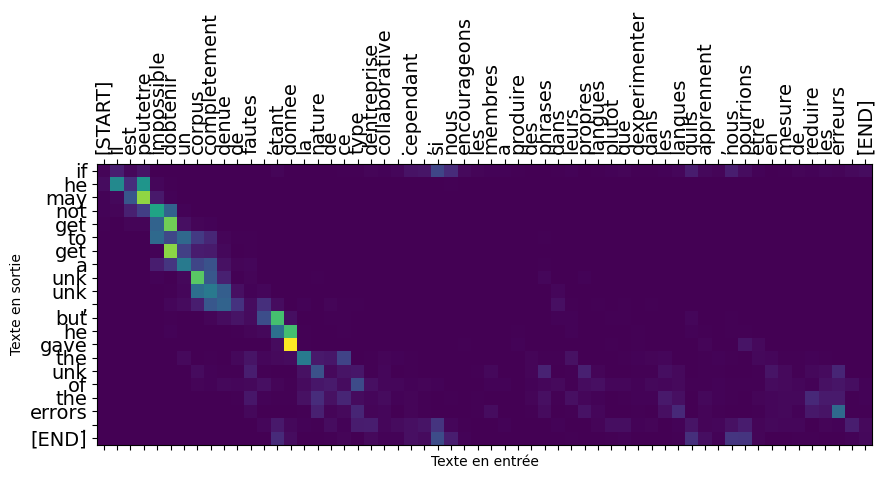

In [ ]:
# Récupérer un long texte pour le test
long_text = context_raw[-1]

# Afficher la traduction attendue
import textwrap
print('Sortie attendue:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

# Tester la visualisation de l'attention sur le long texte
model.plot_attention(long_text)

In [ ]:
# Préparer quelques entrées pour des tests supplémentaires
inputs = [
    'J\'aime les pommes rouges.',
    'Qui es tu ?',
    'Tu es très jolie aujourd\'hui.',
    'Quand viendras tu ?'
]

for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

i like red apples . 
who are you ? 
youre very pretty today . 
when will you give you ? 



# Analyse des résultats

Dans cette partie, nous examinons les résultats de l'entraînement et effectuons différentes analyses sur le modèle.


## Histogramme des gradients

Ce plot vous donnera une idée de la magnitude des gradients pendant l'entraînement.




Nous affichons un histogramme des normes des gradients pour avoir une idée de leur magnitude pendant l'entraînement. Cela peut nous aider à vérifier si les gradients sont trop petits ou trop grands, ce qui pourrait affecter la convergence de l'entraînement.


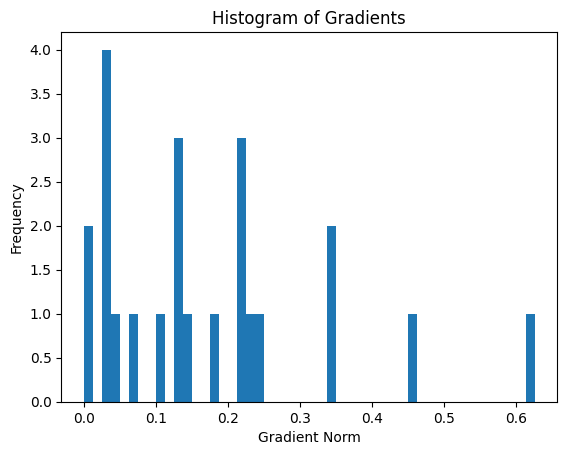

In [ ]:
def plot_gradient_histogram(model):
    with tf.GradientTape() as tape:
        logits = model((ex_context_tok, ex_tar_in))
        loss_value = masked_loss(ex_tar_out, logits)

    grads = tape.gradient(loss_value, model.trainable_variables)
    gradients = [tf.norm(grad).numpy() for grad in grads if grad is not None]

    plt.hist(gradients, bins=50)
    plt.xlabel('Gradient Norm')
    plt.ylabel('Frequency')
    plt.title('Histogram of Gradients')
    plt.show()

# Exemple d'utilisation après chaque époque ou itération :
plot_gradient_histogram(model)


## Courbe de perte par epoch


Nous traçons une courbe pour visualiser l'évolution de la perte d'entraînement et de la perte de validation au fil des époques. Cela nous permet de voir comment la perte change pendant l'entraînement et d'identifier toute tendance de surapprentissage ou de sous-apprentissage.


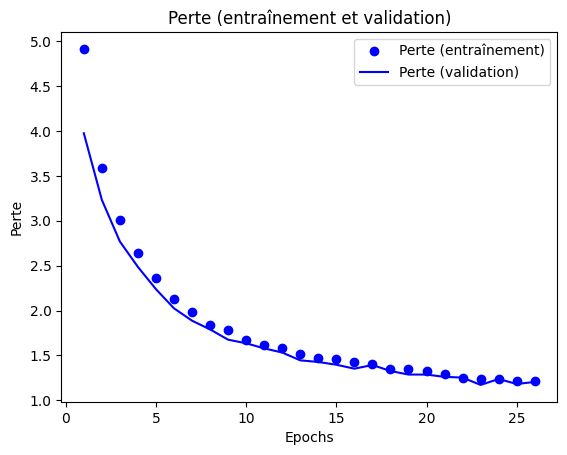

In [ ]:
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Perte (entraînement)')
    plt.plot(epochs, val_loss, 'b', label='Perte (validation)')
    plt.title('Perte (entraînement et validation)')
    plt.xlabel('Epochs')
    plt.ylabel('Perte')
    plt.legend()
    plt.show()

plot_loss(history)

## Courbe de perte en fonction du temps

Nous enregistrons le temps nécessaire pour chaque époque d'entraînement et traçons une courbe pour visualiser la perte en fonction du temps écoulé. Cela nous permet de voir si la perte diminue progressivement au fil du temps et si l'entraînement progresse de manière efficace.


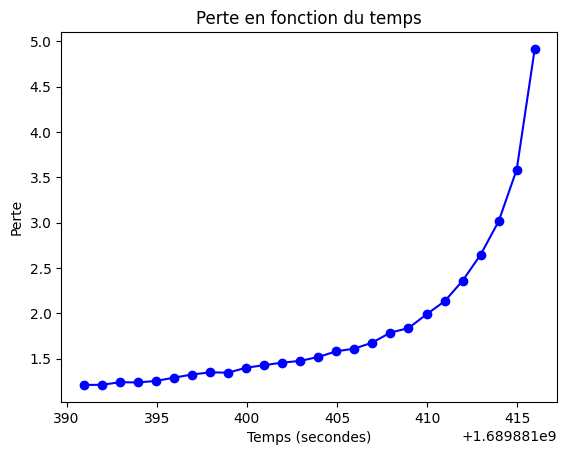

In [ ]:
import time

def plot_loss_vs_time(history):
    loss = history.history['loss']
    timestamps = [time.time() - start_time for start_time in history.epoch]
    plt.plot(timestamps, loss, 'bo-')
    plt.title('Perte en fonction du temps')
    plt.xlabel('Temps (secondes)')
    plt.ylabel('Perte')
    plt.show()

plot_loss_vs_time(history)

## Histogramme de la distribution des pertes



Nous traçons un histogramme pour visualiser la distribution des valeurs de perte pendant l'entraînement. Cela peut nous donner une idée de la variabilité de la perte et de la stabilité de l'entraînement.


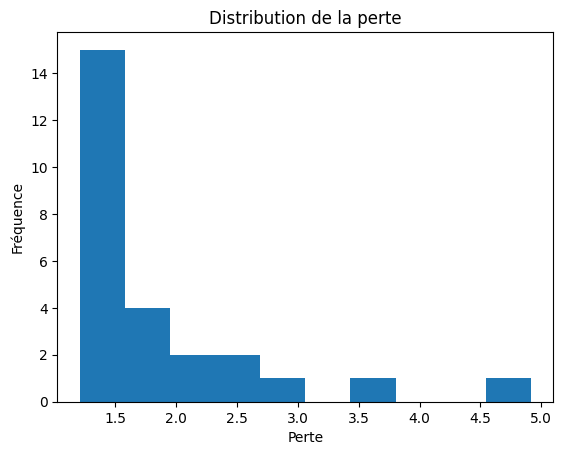

In [ ]:
def plot_loss_distribution(history):
    loss = history.history['loss']
    plt.hist(loss, bins=10)
    plt.title('Distribution de la perte')
    plt.xlabel('Perte')
    plt.ylabel('Fréquence')
    plt.show()

plot_loss_distribution(history)

## Enregistrement des résultats




Enfin, nous enregistrons le modèle entraîné en utilisant la méthode `save` de Keras, ainsi que l'historique d'entraînement sous forme d'un fichier pickle pour pouvoir les réutiliser ultérieurement.

In [ ]:
import pickle

# Enregistrer le modèle
model.save('nom_du_modele')

# Enregistrer l'historique
with open('historique.pkl', 'wb') as f:
    pickle.dump(history.history, f)